<a href="https://colab.research.google.com/github/mondjisola/dpro_divic/blob/master/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## MNIST dataset loading and preprocessing

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Dataset checking
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [ ]:
# Smoothing
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

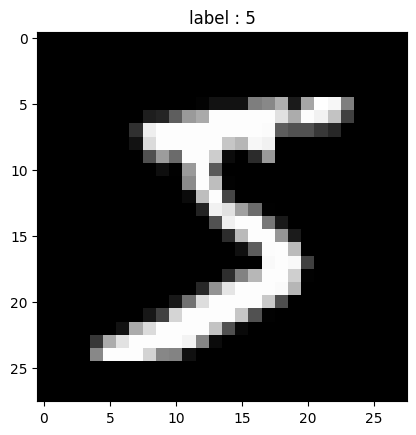

In [ ]:
# Image data vizualization
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
# plt.imshow(image, 'gray')
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [ ]:
# Preprocessing (normalization)
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [ ]:
# Preprocessing : one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [ ]:
# Train and validation set splitting
X_train, X_val, y_train_one_hot, y_val_one_hot = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


## Neural Network scratch

In [ ]:
# Minibatch processing
class GetMiniBatch:
    """
    Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [ ]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    Simple three-layer neural network classifier

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, batch_size = 20, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, sigma = 0.01, lr = 0.01, epoch = 10, verbose=True):
        """
        Constructor definition.

        Parameters
        ----------
        batch_size : int
          Number of data to be trained at one time
        n_features : int
          Number of features quantities of explanatoy variables
        n_nodes1 : int
          Number of nodes in the first layer
        n_nodes2 : int
          Number of nodes in the second layer
        n_output : int
          Nodes in the output layer
        sigma : float
          Mean value of normal distribution
        lr : float
          learning rate
        epoch : int
          Number of epochs
        verbose : bool
          Whether or not to output the learning process
        """

        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        self.loss_train = []
        self.loss_val = []
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)

    def tanh_function(self, A):
        result = np.tanh(A)
        return result

    def softmax(self, A):
        result = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
        return result

    def cross_entropy_error(self, y, Z):
        """
        Cross entropy error calculation function.

        parameters
        ----------
        y : numpy.ndarray, shape(batch_size,)
          Labels
        Z : numpy.ndarray, shape(batch_size, n_output)
          Estimated values
        """
        L = -np.sum(y * np.log(Z + 1e-7)) / len(y)
        return L

    def forward(self, X):
        """
        Forward propagation function.

        Parameters
        ----------
        X : numpy.ndarray, shape (batch_size, n_features)
          Training data (entity matrix)
        """

        self.A1 = X @ self.W1 + self.B1
        self.Z1 = self.tanh_function(self.A1)
        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self.tanh_function(self.A2)
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self.softmax(self.A3)

    def backward(self, X, y):
        """
        Backward propagation function.

        Parameters
        ----------
        X : numpy.ndarray, shape (n_samples, n_features)
          Explanatory variable
        y : numpy.ndarray, shape(n_samples,)
          Objective variable
        """

        dA3 = (self.Z3 - y)/self.batch_size
        dW3 = self.Z2.T @ dA3
        dB3 = np.sum(dA3, axis=0)
        dZ2 = dA3 @ self.W3.T
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dW2 = self.Z1.T @ dA2
        dB2 = np.sum(dA2, axis=0)
        dZ1 = dA2 @ self.W2.T
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dW1 = X.T @ dA1
        dB1 = np.sum(dA1, axis=0)
        self.W3 -= self.lr * dW3
        self.B3 -= self.lr * dB3
        self.W2 -= self.lr * dW2
        self.B2 -= self.lr * dB2
        self.W1 -= self.lr * dW1
        self.B1 -= self.lr * dB1

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.

        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """

        for _ in range(self.epoch):
              get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
              for mini_X_train, mini_y_train in get_mini_batch:
                  self.forward(mini_X_train)
                  self.backward(mini_X_train, mini_y_train)
              self.forward(X)
              self.loss_train.append(self.cross_entropy_error(y, self.Z3))
              if X_val is not None:
                  self.forward(X_val)
                  self.loss_val.append(self.cross_entropy_error(y_val, self.Z3))
        if self.verbose:
            if X_val is None:
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_val)

    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample

        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """

        self.forward(X)
        return np.argmax(self.Z3, axis=1)

In [ ]:
# Learning
nn = ScratchSimpleNeuralNetrowkClassifier(epoch=10)
nn.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

[0.6823344977264375, 0.40449544955771793, 0.3447537257970075, 0.3141474737764776, 0.289855399254285, 0.26922401501272747, 0.2506029018536249, 0.23331535651084592, 0.21705363195180674, 0.20170103147744778] [0.6856616247229002, 0.41653241606204644, 0.35591969190133355, 0.3252113746803187, 0.3014709345037552, 0.2817267251351584, 0.26436512580160704, 0.2486446415114341, 0.23412115333467423, 0.22057260206992368]


In [ ]:
# Estimation and accuracy calculation
y_pred = nn.predict(X_test)
accuracy_score = np.sum(y_pred == y_test) / len(y_test)
print('Accuracy : {:.3f}'.format(accuracy_score))

Accuracy : 0.939


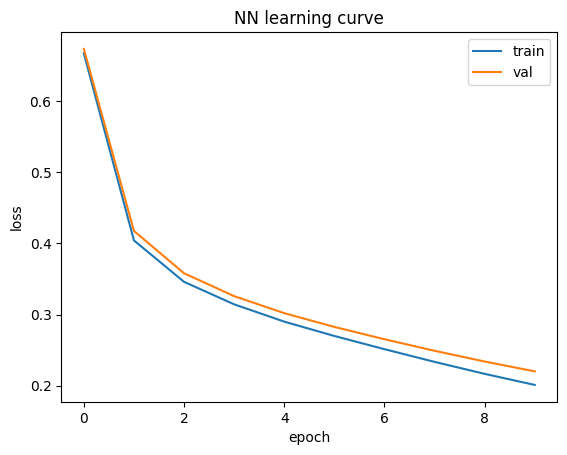

In [ ]:
# Learning curve plotting
plt.plot(range(nn.epoch), nn.loss_train)
plt.plot(range(nn.epoch), nn.loss_val)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('NN learning curve')
plt.show()

In [ ]:
# Missclassification confirmation
def display_missclassification(y_pred, y_val, X_val):
    """
    Display word classification results side by side. The display above the image is "estimated result / correct answer".

    Parameters:
    ----------
    y_pred : Estimated ndarray (n_samples,)
    y_val : Correct label of verification data (n_samples,)
    X_val : Verification data features (n_samples, n_features)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    num = 36 # How many to display

    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(int)

    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

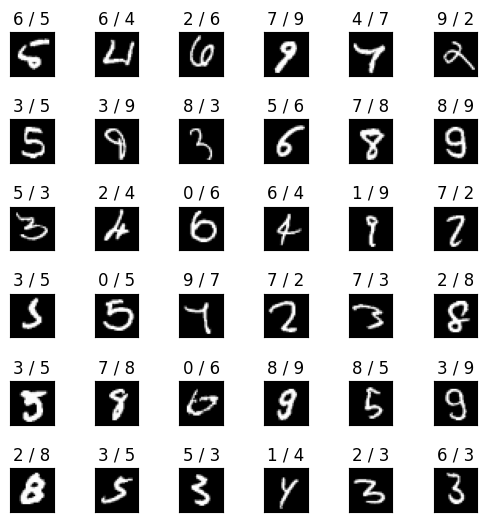

In [ ]:
display_missclassification(y_pred, y_test, X_test)